<a href="https://colab.research.google.com/github/Shaurya-S0603/Stock-Market-Analyzer/blob/main/STOCK_MARKET_ANALYSIS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CREATING THE BOT AND TRAINING IT**

**Importing Required Packages.**

In [56]:
!pip install ta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from ta import add_all_ta_features
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

**Getting the training dataset and exploring it**

In [57]:
# Replace 'stock_symbol' with the stock symbol you want to analyze
stock_symbol = 'GOOG'
extended_end_date = pd.Timestamp.now() + pd.DateOffset(days=30)
stock_data = yf.download(stock_symbol, start='2021-1-1', end=extended_end_date)

[*********************100%***********************]  1 of 1 completed


**Implementing the SMA (Simple Moving Avg) Stratergy**

*   SMA crossover (buy when short-term SMA crosses above long-term SMA, sell when short-term SMA crosses below long-term SMA).


In [58]:
def SMA_strategy(data, short_window=20, long_window=50):
    signals = pd.DataFrame(index=data.index)
    signals['signal'] = 0.0

    signals['short_mavg'] = data['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = data['Close'].rolling(window=long_window, min_periods=1, center=False).mean()

    signals.loc[signals.index[short_window:], 'signal'] = np.where(
    signals['short_mavg'].iloc[short_window:] > signals['long_mavg'].iloc[short_window:],
    1.0,
    0.0
    )

    signals['positions'] = signals['signal'].diff()

    return signals

signals = SMA_strategy(stock_data)

**Visualizing the statergy**

*  Plotting the stock prices along with buy/sell signals based on the SMA strategy.

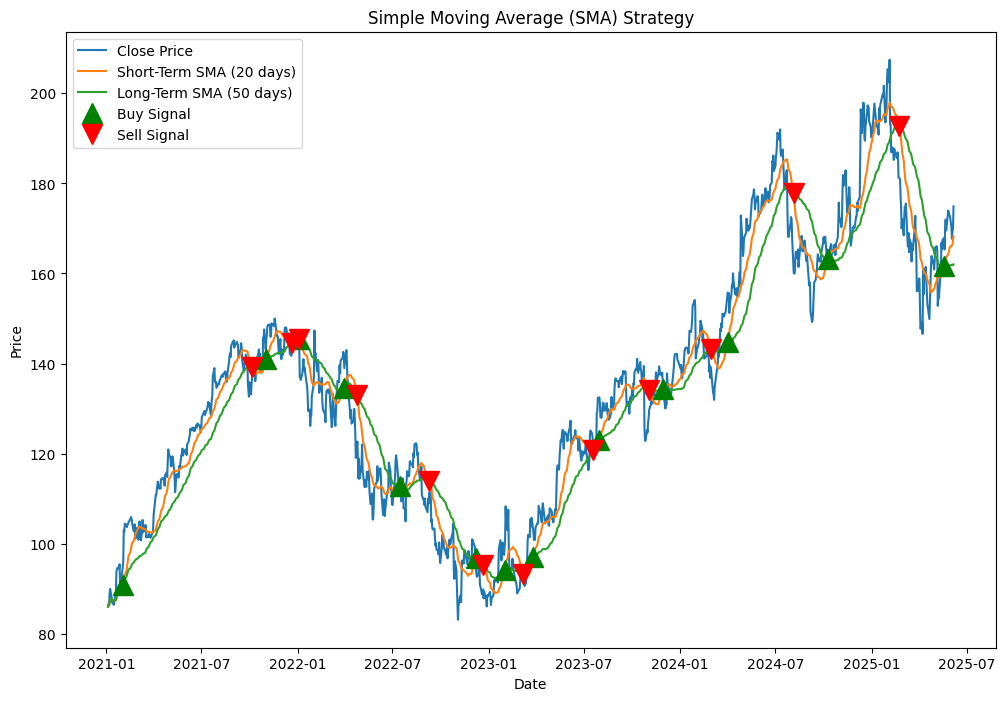

In [59]:
plt.figure(figsize=(12, 8))
plt.plot(stock_data['Close'], label='Close Price')
plt.plot(signals['short_mavg'], label='Short-Term SMA (20 days)')
plt.plot(signals['long_mavg'], label='Long-Term SMA (50 days)')

plt.plot(signals[signals['positions'] == 1.0].index,
         signals['short_mavg'][signals['positions'] == 1.0],
         '^', markersize=15, color='g', lw=0, label='Buy Signal')

plt.plot(signals[signals['positions'] == -1.0].index,
         signals['short_mavg'][signals['positions'] == -1.0],
         'v', markersize=15, color='r', lw=0, label='Sell Signal')

plt.title('Simple Moving Average (SMA) Strategy')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


# **IMPLEMENTATION**

**Backtesting and Performance Evaluation**

*  Backtest the strategy by simulating trades based on historical data and evaluating its performance metrics like returns, Sharpe ratio, etc.



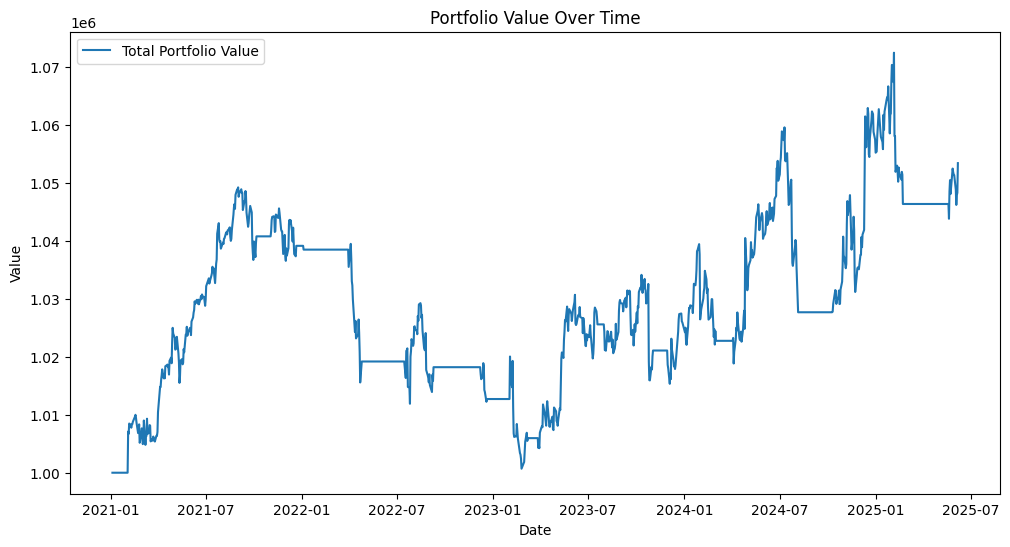

In [60]:
def backtest_strategy(data, signals):
    initial_capital = 1000000

    price_column = 'Adj Close' if 'Adj Close' in data.columns else 'Close'

    positions = pd.DataFrame(index=data.index).fillna(0.0)
    positions[stock_symbol] = 1000 * signals['signal']

    portfolio = positions.multiply(data[price_column], axis=0)
    pos_diff = positions.diff()

    portfolio['holdings'] = positions.multiply(data[price_column], axis=0).sum(axis=1).fillna(0.0)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(data[price_column], axis=0)).sum(axis=1).cumsum()
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()

    return portfolio

portfolio = backtest_strategy(stock_data, signals)

plt.figure(figsize=(12, 6))
plt.plot(portfolio['total'], label='Total Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()


**RESULTS DISPLAY**

In [61]:
total_returns = (portfolio['total'].iloc[-1] - portfolio['total'].iloc[0]) / portfolio['total'].iloc[0] * 100
sharpe_ratio = (portfolio['returns'].mean() / portfolio['returns'].std()) * np.sqrt(252)
accuracy = (signals['positions'].diff() == 0).sum() / len(signals) * 100

print(f"\nTotal Returns: {total_returns:.2f}%")
print(f"\nAnnualized Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"\nAccuracy of Strategy: {accuracy:.2f}%")


Total Returns: 5.34%

Annualized Sharpe Ratio: 0.40

Accuracy of Strategy: 95.41%
